# Sentiment analysis using FinBERT
This paper uses the FinBERT model that has been pre-trained by ProsusAI specifically for financial sentiment analysis. It is based on the BERT architecture and has been pre-trained on a large corpus of financial news articles and reports, making it highly specialized for financial language.  FinBERT is an open-source project making it readily available to the public. 

Among the limitations for this study is the computing power hence, this study shall stick with the un-tuned FinBERT model. Given the small relatively small corpus size, training it However, for other tasks, such as training a large-scale language model or conducting research on rare linguistic phenomena, a larger corpus may be necessary.

## Importing relevant packages

In [20]:
import os
import re
import pandas as pd
import torch
import torch.nn.functional as F
import spacy
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt


## Initializing source directory

In [12]:
# Set the directory containing the CSV files
dir_path = '/Users/jomarjordas/Documents/MSFIN299/MSFIN299-Research/_data/17a_exports'

## Running the input into the FinBERT Model

_Important Note: The codes below are optimized for Macbooks (M1,M2) to make use of the GPU for the task._

### _Document level_

In this section, we will use the FinBERT model to perform sentiment analysis on financial text documents at a document level. 

Each text file containing the scrubbed MD&A of each company for each year shall be subjected into the FinBERT model to generate a sentiment score of either 1, 0, or -1 interpreted as Positive, Neutral, or Negative respectively. 

In [13]:
# Load the FinBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Define the sentiment classes and scores
sentiment_classes = ['positive', 'neutral', 'negative']
sentiment_scores = [1, 0, -1]

# Initialize an empty list to store the results
results_doc = []

# Iterate through all the text files in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(dir_path, filename)
        
        # Read the contents of the text file
        with open(file_path, 'r') as file:
            text = file.read().replace('\n', '')
        
        # Tokenize the text using the BERT tokenizer
        tokens = tokenizer.encode_plus(text, max_length=512, truncation=True, padding='max_length',
                                       add_special_tokens=True, return_tensors='pt')
        device = torch.device('mps')
        model.to(device)
        tokens.to(device)        
        
        # Get the model's output for the tokenized text
        output = model(**tokens)
        
        # Apply softmax to the logits output tensor of our model (in index 0) across dimension -1
        probs = F.softmax(output[0], dim=-1)
        
        # Get the index of the predicted sentiment class
        pred_class_idx = torch.argmax(probs, dim=1)
        
        # Map the predicted sentiment class to a sentiment score and interpretation
        sentiment_score = sentiment_scores[pred_class_idx.item()]
        interpretation = sentiment_classes[pred_class_idx.item()]

        # Extract ticker and year from the filename using regex
        ticker = re.findall(r'^([A-Za-z]+)_\d{4}\.txt$', filename)[0]
        year = re.findall(r'^[A-Za-z]+_(\d{4})\.txt$', filename)[0]
        
        # Add the sentiment score and interpretation to the list of results
        results_doc.append({'file_name': filename, 'ticker': ticker, 'year': year, 'sentiment_score': sentiment_score, 'interpretation': interpretation})

#### Creating a dataframe to show results

In [40]:
# Create a dataframe with the sentiment score and interpretation for each file
df_results_doc = pd.DataFrame(results_doc)

# Print the results dataframe
df = df_results_doc.sort_values('year', ascending=False)

df


,file_name,ticker,year,sentiment_score,interpretation
8,AC_2021.txt,AC,2021,1,positive
15,ACEN_2021.txt,ACEN,2021,-1,negative
3,AGI_2021.txt,AGI,2021,1,positive
18,MEG_2021.txt,MEG,2021,1,positive
10,AEV_2021.txt,AEV,2021,1,positive
17,MEG_2020.txt,MEG,2020,0,neutral
11,AEV_2020.txt,AEV,2020,0,neutral
9,AC_2020.txt,AC,2020,0,neutral
16,ACEN_2020.txt,ACEN,2020,1,positive
4,AGI_2020.txt,AGI,2020,-1,negative


/var/folders/s3/vv9psq2d7nb0zc29tlx4z90m0000gn/T/ipykernel_49733/2046026008.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = results_df.groupby(['ticker', 'year']).mean()


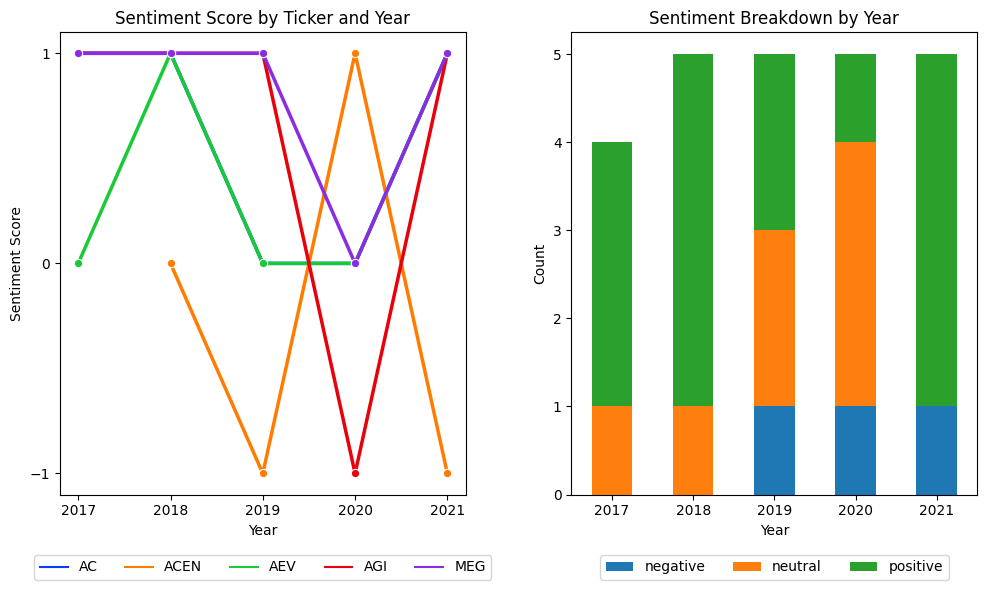

<Figure size 640x480 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Code 1
results_df = pd.DataFrame(results_doc)
results_df['year'] = pd.to_datetime(results_df['year'])
grouped_df = results_df.groupby(['ticker', 'year']).mean()
grouped_df = grouped_df.reset_index()
grouped_df['year'] = grouped_df['year'].astype(str)
pivoted_df = grouped_df.pivot_table(index='year', columns='ticker', values='sentiment_score')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Left plot - Line chart
sns.lineplot(data=grouped_df, x=grouped_df['year'].apply(lambda x: x[:4]), y='sentiment_score', hue='ticker',
             linewidth=2.5, palette='bright', errorbar=None, marker='o', ax=axes[0])
axes[0].set_title('Sentiment Score by Ticker and Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Sentiment Score')
axes[0].set_yticks([-1, 0, 1])
axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(pivoted_df.columns))

# Right plot - Stacked bar chart
grouped_df = results_df.groupby(['year', 'interpretation', 'ticker']).count()
grouped_df = grouped_df.reset_index().rename(columns={'file_name': 'count'})
pivoted_df = grouped_df.pivot_table(index='year', columns='interpretation', values='count', aggfunc=sum)
pivoted_df.plot(kind='bar', stacked=True, figsize=(10, 6), ax=axes[1])
axes[1].set_title('Sentiment Breakdown by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(pivoted_df.index.year, rotation=0)
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(pivoted_df.columns))

plt.tight_layout()
plt.show()
plt.savefig('/Users/jomarjordas/Documents/MSFIN299/MSFIN299-Research/_notebooks/outputcharts/chart1.png')
plt.savefig('/Users/jomarjordas/Documents/MSFIN299/MSFIN299-Research/_notebooks/outputcharts/chart2.png')


### _Sentence  level_
Meanwhile, in this section, we will use the FinBERT model to perform sentiment analysis on financial text documents at a sentence level. The FinBERT model shall be used and iterated for each sentence in the text file to generate a sentiment score of either 1, 0, or -1. 

On a per file basis, the total number of positive, neutral, and negative sentences will be subjected to the following formula to get a sentiment score for the file. 
  
$$Sentiment\ Score_{corpus} = \frac{Positive\ sentence_{count} - Negative\ sentence_{count}}{Total\ Number\ of\ Sentences}$$
  
  
It shall then be interpreted as follows
  
  
$$
\text{Sentiment} =
\begin{cases}
\text{if } 1 > \text{Sentiment score} > 0.05,\text{Positive} \\
\text{if } 0.05 > \text{Sentiment score} > -0.05,\text{Neutral} \\
\text{if } -0.05 > \text{Sentiment score} > -1,\text{Negative} \\
\end{cases}
$$

In [9]:
# Load the Spacy English language model
nlp = spacy.load('en_core_web_lg')

# Load the FinBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Define the sentiment scores and classes
sentiment_scores_sent = [1, 0, -1]
sentiment_classes_sent = ['positive', 'neutral', 'negative']

# Initialize the results list and counters
results_sent = []
pos_count = 0
neu_count = 0
neg_count = 0

# Loop over each text file in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(dir_path, filename)

        # Read the contents of the text file
        with open(file_path, 'r') as file:
            text = file.read()

        # Use Spacy to split the text into sentences
        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents]

        # Initialize the sentence-level results list and counters
        sentence_results = []
        pos_sent_count = 0
        neu_sent_count = 0
        neg_sent_count = 0

        # Loop over each sentence in the text file
        for sentence in sentences:
            # Tokenize the sentence using the FinBERT tokenizer
            tokens = tokenizer.encode_plus(sentence, max_length=512, truncation=True, padding='max_length',
                                           add_special_tokens=True, return_tensors='pt')

            device = torch.device('mps')
            model.to(device)
            tokens.to(device)

            # Get the model's output for the tokenized sentence
            output = model(**tokens.to(device))

            # Apply softmax to the logits output tensor of our model (in index 0) across dimension -1
            probs = F.softmax(output[0], dim=-1)

            # Get the index of the predicted sentiment class
            pred_class_idx = torch.argmax(probs, dim=1)

            # Map the predicted sentiment class to a sentiment score and interpretation
            sentiment_score = sentiment_scores_sent[pred_class_idx.item()]
            if sentiment_score < -0.05:
                interpretation = 'negative'
            elif sentiment_score > 0.05:
                interpretation = 'positive'
            else:
                interpretation = 'neutral'

            # Add the sentiment score and interpretation to the sentence-level results list
            sentence_results.append({'sentence': sentence.strip(), 'sentiment_score': sentiment_score, 'interpretation': interpretation})

            # Update the sentence-level sentiment counters
            if interpretation == 'positive':
                pos_sent_count += 1
            elif interpretation == 'neutral':
                neu_sent_count += 1
            elif interpretation == 'negative':
                neg_sent_count += 1

        # Calculate the overall sentiment score for the corpus
        sentiment_score_corpus = (pos_sent_count - neg_sent_count) / len(sentences)

        # Extract ticker and year from the filename using regex
        ticker = re.findall(r'^([A-Za-z]+)_\d{4}\.txt$', filename)[0]
        year = re.findall(r'^[A-Za-z]+_(\d{4})\.txt$', filename)[0]

        # Add the sentence-level and file-level results to the results list
        results_sent.append({'file_name': filename, 'ticker': ticker, 'year': year, 
                              'sentences': sentence_results, 
                              'positive_sent_count': pos_sent_count,
                              'neutral_sent_count': neu_sent_count,
                              'negative_sent_count': neg_sent_count,
                              'sentiment_score_corpus': sentiment_score_corpus,
                              'corpus_interpretation': 'positive' if sentiment_score_corpus > 0.05 else ('neutral' if -0.05 <= sentiment_score_corpus <= 0.05 else 'negative')})
        
        # Update the file-level sentiment counters
        pos_count += pos_sent_count
        neu_count += neu_sent_count
        neg_count += neg_sent_count


#### Creating a dataframe to show results

In [10]:
# Create a pandas DataFrame from the results list
df = pd.DataFrame(results_sent)

# Add a column for the total sentence count
df['sentence_count'] = df['sentences'].apply(lambda x: len(x))

# Add a column for the total token count
df['token_count'] = df['sentences'].apply(lambda x: sum(len(sentence['sentence'].split()) for sentence in x))

output_dir_path = '/Users/jomarjordas/Documents/MSFIN299/MSFIN299-Research/_data/17a_exports'
output_file_name = 'sent_lvl.csv'
output_file_path = os.path.join(output_dir_path, output_file_name)

# save to csv
df.to_csv(output_file_path, index=False)

df = df.sort_values('year', ascending=False)

df

,file_name,ticker,year,sentences,positive_sent_count,neutral_sent_count,negative_sent_count,sentiment_score_corpus,corpus_interpretation,sentence_count,token_count
8,AC_2021.txt,AC,2021,[{'sentence': 'Ayala Corporation’s net profits...,110,46,68,0.187500,positive,224,5748
15,ACEN_2021.txt,ACEN,2021,[{'sentence': 'The following discussion and an...,54,26,73,-0.124183,negative,153,4303
3,AGI_2021.txt,AGI,2021,[{'sentence': 'The following discussion and an...,62,10,28,0.340000,positive,100,2797
18,MEG_2021.txt,MEG,2021,"[{'sentence': 'Megaworld, the country’s larges...",23,7,21,0.039216,neutral,51,1642
10,AEV_2021.txt,AEV,2021,[{'sentence': 'The following discussion and an...,201,24,88,0.361022,positive,313,8341
17,MEG_2020.txt,MEG,2020,"[{'sentence': 'Megaworld, the country’s larges...",17,14,21,-0.076923,negative,52,1603
11,AEV_2020.txt,AEV,2020,[{'sentence': 'The following discussion and an...,155,61,52,0.384328,positive,268,7140
9,AC_2020.txt,AC,2020,[{'sentence': 'The further easing of quarantin...,113,78,75,0.142857,positive,266,6637
16,ACEN_2020.txt,ACEN,2020,[{'sentence': 'The following discussion and an...,40,16,26,0.170732,positive,82,2176
4,AGI_2020.txt,AGI,2020,[{'sentence': 'The following discussion and an...,62,51,45,0.107595,positive,158,4044
